<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import wget
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

### Load Data From CSV File  

In [2]:
df = pd.read_csv('loan_train.csv')
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30       9/8/2016   
1           2             2     PAIDOFF       1000     30       9/8/2016   
2           3             3     PAIDOFF       1000     15       9/8/2016   
3           4             4     PAIDOFF       1000     30       9/9/2016   
4           6             6     PAIDOFF       1000     30       9/9/2016   

    due_date  age             education  Gender  
0  10/7/2016   45  High School or Below    male  
1  10/7/2016   33              Bechalor  female  
2  9/22/2016   27               college    male  
3  10/8/2016   28               college  female  
4  10/8/2016   29               college    male

In [3]:
df.shape

(346, 10)

### Convert to date time object 

In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  
0 2016-10-07   45  High School or Below    male  
1 2016-10-07   33              Bechalor  female  
2 2016-09-22   27               college    male  
3 2016-10-08   28               college  female  
4 2016-10-08   29               college    male

# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

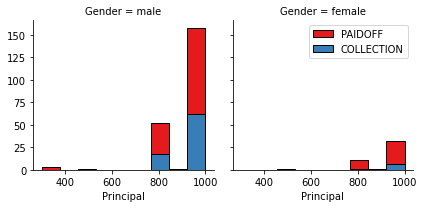

In [6]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

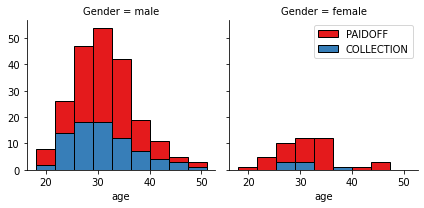

In [7]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

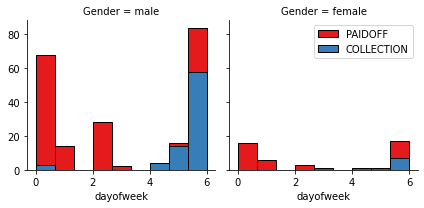

In [8]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [9]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()
df.shape

(346, 12)

## Convert Categorical features to numerical values

Lets look at gender:

In [10]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [11]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  dayofweek  weekend  
0 2016-10-07   45  High School or Below       0          3        0  
1 2016-10-07   33              Bechalor       1          3        0  
2 2016-09-22   27               college       0          3        0  
3 2016-10-08   28               college       1          4        1  
4 2016-10-08   29               college       0          4        1

In [12]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

## One Hot Encoding  
#### How about education?

#### Feature befor One Hot Encoding

In [13]:
df[['Principal','terms','age','Gender','education']].head()

Principal  terms  age  Gender             education
0       1000     30   45       0  High School or Below
1       1000     30   33       1              Bechalor
2       1000     15   27       0               college
3       1000     30   28       1               college
4       1000     30   29       0               college

#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [14]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()
Feature.shape


(346, 8)

### Feature selection

Lets defind feature sets, X:

In [15]:
X = Feature
X[0:5]

Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   45       0        0         0                     1   
1       1000     30   33       1        0         1                     0   
2       1000     15   27       0        0         0                     0   
3       1000     30   28       1        1         0                     0   
4       1000     30   29       0        1         0                     0   

   college  
0        0  
1        0  
2        1  
3        1  
4        1

What are our lables?

In [16]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [17]:
X = X.astype(float)
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 4)
print("Train set: ", x_train.shape, y_train.shape)
print("Train set: ", x_test.shape, y_test.shape)

Train set:  (276, 8) (276,)
Train set:  (70, 8) (70,)


In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
k = 15
mean_acc = np.zeros((k-1))
confusion_Mx = [];
for i in range(1,k):
    neigh = KNeighborsClassifier(n_neighbors=i).fit(x_train, y_train)
    y_hat = neigh.predict(x_test)
    mean_acc[i-1] = metrics.jaccard_similarity_score(y_test, y_hat)
accuracy_score = mean_acc.max()
print("Best Accuracy Score : %.2f" % accuracy_score)
print("Best k value: ", mean_acc.argmax()+1)

Best Accuracy Score : 0.79
Best k value:  7


In [20]:
#Jaccard and F1 Score on train set using k = 7
k = 7
neigh_fin = KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train)

y_for_new_k = neigh_fin.predict(x_test)

train_acc_jac = metrics.jaccard_similarity_score(y_test, y_for_new_k)
train_acc_f1 = metrics.f1_score(y_test, y_for_new_k, average='weighted')

print("Jaccard Index :%.2f " % train_acc_jac)
print("F1 Score:%.2f " % train_acc_f1)

print("Best k value: 7")

Jaccard Index :0.79 
F1 Score:0.78 
Best k value: 7


# Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier
X = Feature
y = df['loan_status']

In [22]:
#Test/Train split and model fitting
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 2)
loanTree = DecisionTreeClassifier(criterion='entropy', max_depth=3)
loanTree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
#Prediting and evaluating the model on the loan_train dataset
predTree = loanTree.predict(x_test)
dt_acc = metrics.accuracy_score(y_test, predTree)
print("Accuracy Score: ", dt_acc)
print("F1 Score: %.2f " % metrics.f1_score(y_test, predTree, average="weighted"))


Accuracy Score:  0.8
F1 Score: 0.74 


# Support Vector Machine

In [24]:
X = Feature
X = np.asarray(X)
y = np.asarray(y)

In [25]:
from sklearn import svm
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 2)
clf = svm.SVC(kernel='rbf', gamma = 'auto')
clf.fit(x_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
#Predicting on the test set
yhat = clf.predict(x_test)

In [27]:
#Evaluating the accuracy on the loan_train dataset
from sklearn.metrics import f1_score
F1 = f1_score(y_test, yhat, average='weighted')
print("F1 Score: %.2f"% F1)

F1 Score: 0.75


# Logistic Regression

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

In [29]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='lbfgs').fit(x_train, y_train)

In [30]:
#Predicting on the test set
y_hat = LR.predict(x_test)
y_hat_prob = LR.predict_proba(x_test)

In [31]:
#Evaluating the accuracy on the loan_train dataset
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

jac = jaccard_similarity_score(y_test, y_hat)
log = log_loss(y_test, y_hat_prob)
F1 = f1_score(y_test, y_hat, average='weighted')

print("Jaccard Score: %.2f"%jac)
print("Log loss Score: %.2f"%log)
print("F1 Score: %.2f"%F1)

Jaccard Score: 0.79
Log loss Score: 0.54
F1 Score: 0.69


c:\users\foxrine\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Model Evaluation using Test set

In [32]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

### Load Test set for evaluation 

In [33]:
#Loading the dataset on pandas dataframe
test_df = pd.read_csv('loan_test.csv')
test_df.head(5)

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30       9/8/2016   
1           5             5     PAIDOFF        300      7       9/9/2016   
2          21            21     PAIDOFF       1000     30      9/10/2016   
3          24            24     PAIDOFF       1000     30      9/10/2016   
4          35            35     PAIDOFF        800     15      9/11/2016   

    due_date  age             education  Gender  
0  10/7/2016   50              Bechalor  female  
1  9/15/2016   35       Master or Above    male  
2  10/9/2016   43  High School or Below  female  
3  10/9/2016   26               college    male  
4  9/25/2016   29              Bechalor    male

In [34]:
#Data preprocessing and feature selection of the loan_test dataset
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
print(test_df.shape)
print(test_df['loan_status'].value_counts())

(54, 10)
PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64


In [35]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.shape

(54, 12)

In [36]:
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30     2016-09-08   
1           5             5     PAIDOFF        300      7     2016-09-09   
2          21            21     PAIDOFF       1000     30     2016-09-10   
3          24            24     PAIDOFF       1000     30     2016-09-10   
4          35            35     PAIDOFF        800     15     2016-09-11   

    due_date  age             education  Gender  dayofweek  weekend  
0 2016-10-07   50              Bechalor       1          3        0  
1 2016-09-15   35       Master or Above       0          4        1  
2 2016-10-09   43  High School or Below       1          5        1  
3 2016-10-09   26               college       0          5        1  
4 2016-09-25   29              Bechalor       0          6        1

In [37]:
feature = test_df[['Principal','terms','age','Gender','weekend']]
feature = pd.concat([feature,pd.get_dummies(test_df['education'])], axis=1)
feature.drop(['Master or Above'], axis = 1,inplace=True)
feature.head()

Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   50       1        0         1                     0   
1        300      7   35       0        1         0                     0   
2       1000     30   43       1        1         0                     1   
3       1000     30   26       0        1         0                     0   
4        800     15   29       0        1         1                     0   

   college  
0        0  
1        0  
2        0  
3        1  
4        0

In [38]:
X_new = feature
X_new = X_new.astype(float)
y_new = test_df['loan_status'].values
X_new = preprocessing.StandardScaler().fit(X_new).transform(X_new)

In [39]:
#KNN On Test Set

y_hat_new = neigh_fin.predict(X_new)

knn_jac = metrics.jaccard_similarity_score(y_new, y_hat_new)
knn_f1 = metrics.f1_score(y_new, y_hat_new, average='weighted')

print("Jaccard Index Score :%.2f " % knn_jac)
print("F1 Score: %.2f"% knn_f1)

Jaccard Index Score :0.67 
F1 Score: 0.63


In [40]:
#Decision Tree On Test Set

X_dt = feature
y_dt = test_df['loan_status']

y_hat_dt_new = loanTree.predict(X_dt)


dt_jac = metrics.jaccard_similarity_score(y_dt, y_hat_dt_new)
dt_f1 = metrics.f1_score(y_dt,y_hat_dt_new, average="weighted")
print("Jaccard Index Score: %.2f" % dt_jac)
print("F1 Score: %.2f" % dt_f1)


Jaccard Index Score: 0.76
F1 Score: 0.71


In [41]:
#SVM on test set

X_sv = feature
X_sv = X_sv.astype('float')
X_sv = np.asarray(X_sv)

y_sv = test_df['loan_status']
y_sv = np.asarray(y_sv)

In [42]:
y_hat_sv = clf.predict(X_sv)

F1 = f1_score(y_sv, y_hat_sv, average='weighted')
jac = jaccard_similarity_score(y_sv, y_hat_sv)

print("Jaccard Score: %.2f"% jac)
print("F1 Score: %.2f" % F1)

Jaccard Score: 0.74
F1 Score: 0.66


In [43]:
#Logistic Regression on test set

X_lr = feature
X_lr = np.asarray(X_lr)
X_lr = X_lr.astype('float')
X = preprocessing.StandardScaler().fit(X_lr).transform(X_lr)

y_lr = test_df['loan_status']
y_lr = np.asarray(y_lr)

In [44]:
y_hat_lr = LR.predict(X)
y_hat_lr_prob = LR.predict_proba(X)

In [45]:
jac_lr = jaccard_similarity_score(y_lr, y_hat_lr)
logs = log_loss(y_lr, y_hat_lr_prob)
F1 = f1_score(y_lr, y_hat_lr, average='weighted')

print("Jaccard Score: %.2f"%jac)
print("Log loss Score: %.2f"%logs)
print("F1 Score: %.2f"%F1)

Jaccard Score: 0.74
Log loss Score: 0.66
F1 Score: 0.61


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>